<a href="https://colab.research.google.com/github/shikarRajcomar-Engineer/Ensemble/blob/master/Model_Imgag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Set up Tensorboard Logging**

In [ ]:
%load_ext tensorboard


# Clear any tensorflow logs from previous runs
!rm -rf ./logs/ 

**Import Dataset**

Datset are in the form of Numpy arrays


In [2]:
import numpy as np 
from os import listdir
from os.path import isfile, join
import cv2
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import sys
import shutil
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras import backend as K
import pandas as pd
from sklearn.metrics import classification_report
from numpy.random import seed
from matplotlib import pyplot
from numpy import expand_dims
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
import sklearn
import datetime, os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import os
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import datetime as datetime
import tensorflow
tensorflow.random.set_seed(1234)
from skimage import transform as tf

import random


path='/content/drive/My Drive/Balanced Brain Training Augmentation only/'
Dataset='Original224'
batch_size=32


def load_data_training_and_test(datasetname):
        npzfile=np.load(path+datasetname+'training_data.npz')
        train=npzfile['arr_0']
        

        npzfile=np.load(path+datasetname+'training_labels.npz')
        train_labels=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_data.npz')
        test=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_labels.npz')
        test_labels=npzfile['arr_0']    
        return (train,train_labels),(test,test_labels)

(x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset)


Using TensorFlow backend.


**Data Normalization**

Total number of outputs :  2
Output classes :  [0 1]
(224, 224, 3)
132


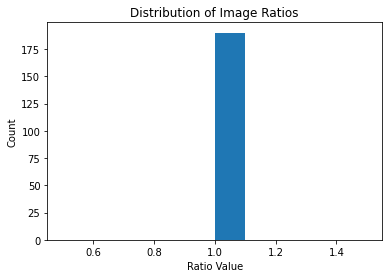

In [3]:


y_train=y_train.reshape(y_train.shape[0],1)
y_testing=y_testing.reshape(y_testing.shape[0],1)

x_train=x_train.astype('float32')
x_test=x_test.astype('float32')

x_train/=255
x_test/=255
training_size=len(x_train)
test_size=len(y_testing)
classes = np.unique(y_train)
nClasses = len(classes)
num_classes = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
img_rows=x_train[0].shape[0]
img_cols=x_train[1].shape[0]
input_shape=(img_rows,img_cols,3)
print(input_shape)
print(len(x_train))


y = dict()
y[0] = []
y[1] = []
for set_name in (y_train,y_testing):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(x=['Train Set', 'Test Set'],y=y[0],name='No',marker=dict(color='#33cc33'),opacity=0.7)
trace1 = go.Bar(x=['Train Set','Test Set'],y=y[1],name='Yes',marker=dict(color='#ff3300'),opacity=0.7)
data = [trace0, trace1]
layout = go.Layout(title='Count of classes in each set',xaxis={'title': 'Set'},yaxis={'title': 'Count'})
fig = go.Figure(data, layout)
iplot(fig)



RATIO_LIST = []
for set in (x_train, x_test):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

**Define Image generators**

In [ ]:
from ImageDataAugmentor.image_data_augmentor import *
from imgaug import augmenters as iaa
import imgaug as ia

...

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
AUGMENTATIONS = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    sometimes(iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 90-110% of their size, individually per axis
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -10 to +10 percent (per axis)
        rotate=(-45, 45), # rotate by -45 to +45 degrees
        shear=(-5, 5), # shear by -5 to +5 degrees
        mode=ia.ALL # use any of scikit-image's warping modes
    )
    )],
    random_order=True)    

datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

# Define Callback function for early stopping and tensorboard
earlystop=EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy'
                                        ,patience=5
                                        ,verbose=0
                                        ,factor=0.5
                                        ,min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d%h$m%s"))
Logger=keras.callbacks.TensorBoard(log_dir=logdir,write_graph=True,histogram_freq=1)

In [ ]:
pip install git+https://github.com/mjkvaak/ImageDataAugmentor

**CNN Architecture**

In [ ]:
from keras.applications.vgg16 import VGG16
# load the model
model = VGG16()
# summarize the model


# from keras.regularizers import l2
# model=Sequential()
# model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(0.001), input_shape=x_train.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(2,2))


# model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.001)))
# model.add(Activation('relu'))


# model.add(Conv2D(160, (3, 3), kernel_regularizer=l2(0.001)))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))

# model.add(Conv2D(160, (3, 3), kernel_regularizer=l2(0.001)))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))

# # model.add(Conv2D(160, (3, 3), kernel_regularizer=l2(0.00001)))
# # model.add(Activation('relu'))
# # model.add(Dropout(0.2)
# # model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(0.0001)))
# # model.add(Activation('relu'))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
# model.add(Dense(2))
# model.add(Dropout(0.2))
# model.add(Activation("softmax"))
# print(model.summary())


optimizer = keras.optimizers.Adam(lr=0.00001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# sparse_categorical_crossentropy

# Logger=keras.callbacks.TensorBoard(log_dir=logdir,write_graph=True,histogram_freq=1)

# print("Number of weights after calling the model:", len(model.weights)) 


**Fit Model**

In [ ]:
epochs=50

mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)


# fit model
train_generator = datagen.flow(x_train,y_train,batch_size=batch_size)

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow(x_test,y_testing,batch_size=batch_size)

history = model.fit_generator(
      train_generator,
      epochs=epochs,
      validation_data=validation_generator,
      verbose=1,
      shuffle=True
      ,
     callbacks=[earlystop, learning_rate_reduction,mc]
     )

# print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
# history.history['val_loss'][-1], 
# history.history['val_accuracy'][-1]))

# saved_model = load_model('best_model.h5')
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_testing, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

his_df=pd.DataFrame(history.history)

predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_testing, predicted_classes, target_names=target_names))

Epoch 1/50
5/5 [==============================] - 1s 263ms/step - loss: 0.7113 - accuracy: 0.5303 - val_loss: 0.8108 - val_accuracy: 0.5172
Epoch 2/50
5/5 [==============================] - 1s 255ms/step - loss: 0.7235 - accuracy: 0.5303 - val_loss: 0.7053 - val_accuracy: 0.4828
Epoch 3/50
5/5 [==============================] - 1s 253ms/step - loss: 0.6988 - accuracy: 0.4697 - val_loss: 0.7055 - val_accuracy: 0.5172
Epoch 4/50
5/5 [==============================] - 1s 252ms/step - loss: 0.7225 - accuracy: 0.4242 - val_loss: 0.7057 - val_accuracy: 0.4828
Epoch 5/50
5/5 [==============================] - 1s 251ms/step - loss: 0.6958 - accuracy: 0.5152 - val_loss: 0.7610 - val_accuracy: 0.5172
Epoch 6/50
5/5 [==============================] - 1s 252ms/step - loss: 0.7520 - accuracy: 0.5303 - val_loss: 0.7003 - val_accuracy: 0.4828
Epoch 7/50
5/5 [==============================] - 1s 252ms/step - loss: 0.7299 - accuracy: 0.4697 - val_loss: 0.6950 - val_accuracy: 0.4828
Epoch 8/50
5/5 [====

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



**Plot the training and validation accuracy**

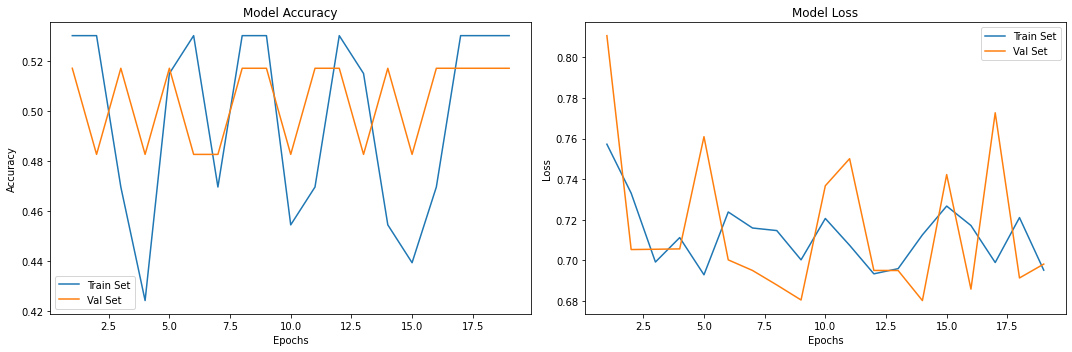

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


# predictions =model.predict_classes(x_test, verbose=1)
# validate on val set

# predictions = [1 if x>0.5 else 0 for x in predictions]
# print(predictions)
# accuracy = accuracy_score(y_testing, predictions)
# print('Val Accuracy = %.2f' % accuracy)

# confusion_mtx = confusion_matrix(y_testing, predictions) 
# cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

**Calculate roc curve and area under curve**

In [ ]:
fpr , tpr , thresholds = roc_curve ( y_testing , y_val_cat_prob)
def plot_roc_curve(fpr,tpr): 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    
plot_roc_curve (fpr,tpr)


auc_score=roc_auc_score(y_testing,y_val_cat_prob)
print(auc_score)

**Confusion Matrix**

In [ ]:
his_df=pd.DataFrame(history.history)

predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_testing, predicted_classes, target_names=target_names))


confusion_mtx = confusion_matrix(y_testing, predicted_classes) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)




**Save** **Model** 

In [ ]:
%tensorboard --port=5036 --logdir $logdir

In [ ]:

model.save('/content/drive/My Drive/Tensorflow/No Aug Path.h5')

In [ ]:
!kill 606

In [4]:
import numpy as np 
from os import listdir
from os.path import isfile, join
import cv2
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import sys
import shutil
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras import backend as K
import pandas as pd
from sklearn.metrics import classification_report
from numpy.random import seed
from matplotlib import pyplot
from numpy import expand_dims
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
import sklearn
import datetime, os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import os
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import datetime as datetime
import tensorflow
tensorflow.random.set_seed(1234)
from skimage import transform as tf

import random




path='/content/drive/My Drive/Balanced Brain Training Augmentation only/'
batch_size=32

# Dataset=['brain_tumor_dataset244','brain_tumor_dataset244starry_night','brain_tumor_dataset244the_wave'
# ,'brain_tumor_dataset244udnie','brain_tumor_dataset244candy','brain_tumor_dataset244composition_vii'
# ,'brain_tumor_dataset244feathers','brain_tumor_dataset244la_muse','brain_tumor_dataset244mosaic','brain_tumor_dataset244scream']


Dataset=['Original224'
,'Brain_HorizontalFlipping224'
,'Brain_vertical_flip224'
,'Brain_rotation_range224'
,'Brain_shear_range224'
,'Brain_width_shift_range224'
,'Brain_Height_shift_range224'
,'Brain_channel_shift_range224'
,'starry_night224'
,'the_wave224'
,'udnie224'
,'candy224'
,'composition_vii224'
,'feathers224'
,'la_muse224'
,'mosaic224'
,'the_scream224']

# Dataset=['Original224','NSTstarry_night_covid224','NSTthe_wave224'
# ,'NSTudnie_covid224','NSTcandy_covid224','NSTcomposition_vii_covid224'
# ,'NSTfeathers_covid224','NSTla_muse_covid224','NSTmosaic_covid224','NSTthe_scream224','samplepair_covid224']

batch_size=32
steps=100

# Define Callback function for early stopping and tensorboard
earlystop=EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy'
                                        ,patience=5
                                        ,verbose=0
                                        ,factor=0.5
                                        ,min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d%h$m%s"))
Logger=keras.callbacks.TensorBoard(log_dir=logdir,write_graph=True,histogram_freq=1)

from keras.applications.vgg16 import VGG16
# load the model
model = VGG16()
# summarize the model

optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])




def load_data_training_and_test(datasetname):
        npzfile=np.load(path+datasetname+'training_data.npz')
        train=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'training_labels.npz')
        train_labels=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_data.npz')
        test=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_labels.npz')
        test_labels=npzfile['arr_0']    
        return (train,train_labels),(test,test_labels)

# (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset)

def data_processing(x_train,y_train,x_test,y_testing):
    y_train=y_train.reshape(y_train.shape[0],1)
    y_testing=y_testing.reshape(y_testing.shape[0],1)
    x_train=x_train.astype('float32')
    x_test=x_test.astype('float32')

    x_train/=255
    x_test/=255
    classes = np.unique(y_train)
    nClasses = len(classes)
    num_classes = len(classes)
    img_rows=x_train[0].shape[0]
    img_cols=x_train[1].shape[0]
    input_shape=(img_rows,img_cols,3)
    return x_train,y_train, x_test,y_testing

# 
batch_size=32
steps=100
def train_on_x_samples(x_train,y_train, x_test,y_testing):
        validation_generator = val_datagen.flow(x_test,y_testing,batch_size=batch_size)
        train_generator = datagen.flow(x_train,y_train,batch_size=batch_size)
        history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=steps,
                    epochs=epochs,
                    verbose=0,
                    shuffle=True,
                    callbacks=[earlystop, learning_rate_reduction,mc],
                    validation_data=validation_generator )

        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        # epochs_range = range(1, len(history.epoch) + 1)
        # plt.figure(figsize=(15,5))

        # plt.subplot(1, 2, 1)
        # plt.plot(epochs_range, acc, label='Train Set')
        # plt.plot(epochs_range, val_acc, label='Val Set')
        # plt.legend(loc="best")
        # plt.xlabel('Epochs')
        # plt.ylabel('Accuracy')
        # plt.title('Model Accuracy')

        # plt.subplot(1, 2, 2)
        # plt.plot(epochs_range, loss, label='Train Set')
        # plt.plot(epochs_range, val_loss, label='Val Set')
        # plt.legend(loc="best")
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.title('Model Loss')

        # plt.tight_layout()
        # plt.show()

        return history



def train_acc_results(x_train,y_train):
    _, train_acc = model.evaluate(x_train, y_train, verbose=0)
    print('Train: %.3f' % (train_acc))
    a=train_acc
    return train_acc

def test_acc_results(x_test,y_testing):
    _, test_acc = model.evaluate(x_test,y_testing, verbose=0)
    print('Test: %.3f' % ( test_acc))
    v=test_acc
    return test_acc


mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


553467904/553467096 [==============================] - 12s 0us/step


In [5]:
epochs=50

i=0
Results=pd.DataFrame([])
hist_results=[]
Aug=['Original','HorizontalFlip','vertialFLip','Rotation','shear','width_shift_range','height_shift_range','Channel shift']
dataset_no=0
for dataset in range(len(Dataset)):
  for i in range(len(Aug)):
    if i==0:
      num_classes=2
      (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[dataset_no])
      data_processing(x_train,y_train,x_test,y_testing)
      a=x_train
      b=y_train
      c=x_test
      d=y_testing




      datagen = ImageDataGenerator(rescale=1./255)
      val_datagen = ImageDataGenerator(rescale=1./255)
      history = train_on_x_samples(x_train,y_train, x_test,y_testing)
      train_acc_results(x_train,y_train)
      test_acc_results(x_test,y_testing)
      his_df=pd.DataFrame(history.history)

      predicted_classes = model.predict(x_test)
      predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
      target_names = ["Class {}".format(i) for i in range(num_classes)]
      report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
      df=pd.DataFrame(report_dict)
      df['aug']=Aug[i]
      df['dataset']=Dataset[dataset]
      df['val acc']=(history.history['val_accuracy'][-1])*100
      df['acc']=(history.history['accuracy'][-1])*100
      print(df)
      Results=Results.append(df)
      i+=1

    elif i==1:
      num_classes=2
      (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[dataset_no])
      data_processing(x_train,y_train,x_test,y_testing)
      datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True)
      val_datagen =  ImageDataGenerator(rescale=1./255)
      history = train_on_x_samples(x_train,y_train, x_test,y_testing)
      train_acc_results(x_train,y_train)
      test_acc_results(x_test,y_testing)
      his_df=pd.DataFrame(history.history)
      predicted_classes = model.predict(x_test)
      predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
      target_names = ["Class {}".format(i) for i in range(num_classes)]
      report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
      df=pd.DataFrame(report_dict)
      df['aug']=Aug[i]
      df['dataset']=Dataset[dataset]
      df['val acc']=(history.history['val_accuracy'][-1])*100
      df['acc']=(history.history['accuracy'][-1])*100
      print(df)
      Results=Results.append(df)
      i+=1

    elif i==2:
      num_classes=2
      (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[dataset_no])
      data_processing(x_train,y_train,x_test,y_testing)
      datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,vertical_flip=True)
      val_datagen =  ImageDataGenerator(rescale=1./255)
      history = train_on_x_samples(x_train,y_train, x_test,y_testing)
      train_acc_results(x_train,y_train)
      test_acc_results(x_test,y_testing)
      his_df=pd.DataFrame(history.history)
      predicted_classes = model.predict(x_test)
      predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
      target_names = ["Class {}".format(i) for i in range(num_classes)]
      report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
      df=pd.DataFrame(report_dict)
      df['aug']=Aug[i]
      df['dataset']=Dataset[dataset]  
      df['val acc']=(history.history['val_accuracy'][-1])*100
      df['acc']=(history.history['accuracy'][-1])*100
      print(df)
      Results=Results.append(df)
      i+=1

    elif i==3:
      num_classes=2
      (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[dataset_no])
      data_processing(x_train,y_train,x_test,y_testing)
      datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=(random.randrange(0,360,30)))
      val_datagen =  ImageDataGenerator(rescale=1./255)
      history = train_on_x_samples(x_train,y_train, x_test,y_testing)
      train_acc_results(x_train,y_train)
      test_acc_results(x_test,y_testing)
      his_df=pd.DataFrame(history.history)
      predicted_classes = model.predict(x_test)
      predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
      target_names = ["Class {}".format(i) for i in range(num_classes)]
      report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
      df=pd.DataFrame(report_dict)
      df['aug']=Aug[i]
      df['dataset']=Dataset[dataset]
      df['val acc']=(history.history['val_accuracy'][-1])*100
      df['acc']=(history.history['accuracy'][-1])*100
      print(df)
      Results=Results.append(df)
      i+=1

    elif i==4:
      (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[dataset_no])
      data_processing(x_train,y_train,x_test,y_testing)
      datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,shear_range=(random.randrange(0,100,10)))
      val_datagen =  ImageDataGenerator(rescale=1./255)
      history = train_on_x_samples(x_train,y_train, x_test,y_testing)
      train_acc_results(x_train,y_train)
      test_acc_results(x_test,y_testing)
      his_df=pd.DataFrame(history.history)
      predicted_classes = model.predict(x_test)
      predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
      target_names = ["Class {}".format(i) for i in range(num_classes)]
      report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
      df=pd.DataFrame(report_dict)
      df['aug']=Aug[i]
      df['dataset']=Dataset[dataset]
      df['val acc']=(history.history['val_accuracy'][-1])*100
      df['acc']=(history.history['accuracy'][-1])*100
      print(df)
      Results=Results.append(df)
      i+=1

    elif i==5:
      num_classes=2
      (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[dataset_no])
      data_processing(x_train,y_train,x_test,y_testing)
      datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,width_shift_range=(random.uniform(0.1,0.9)))
      val_datagen =  ImageDataGenerator(rescale=1./255)
      history = train_on_x_samples(x_train,y_train, x_test,y_testing)
      train_acc_results(x_train,y_train)
      test_acc_results(x_test,y_testing)
      his_df=pd.DataFrame(history.history)
      predicted_classes = model.predict(x_test)
      predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
      target_names = ["Class {}".format(i) for i in range(num_classes)]
      report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
      df=pd.DataFrame(report_dict)
      df['aug']=Aug[i]
      df['dataset']=Dataset[dataset]
      df['val acc']=(history.history['val_accuracy'][-1])*100
      df['acc']=(history.history['accuracy'][-1])*100
      print(df)
      Results=Results.append(df)
      i+=1

    elif i==6:
      num_classes=2
      (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[dataset_no])
      data_processing(x_train,y_train,x_test,y_testing)
      datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,height_shift_range=(random.uniform(0.1,0.9)))
      val_datagen =   ImageDataGenerator(rescale=1./255)
      history = train_on_x_samples(x_train,y_train, x_test,y_testing)
      train_acc_results(x_train,y_train)
      test_acc_results(x_test,y_testing)
      his_df=pd.DataFrame(history.history)
      predicted_classes = model.predict(x_test)
      predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
      target_names = ["Class {}".format(i) for i in range(num_classes)]
      report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
      df=pd.DataFrame(report_dict)
      df['aug']=Aug[i]
      df['dataset']=Dataset[dataset]
      df['val acc']=(history.history['val_accuracy'][-1])*100
      df['acc']=(history.history['accuracy'][-1])*100
      print(df)
      Results=Results.append(df)
      i+=1


      if i==7:
        break
        i=0
  dataset_no=dataset_no+1
  if i==16:
        break
  pd.set_option("display.max_rows", None, "display.max_columns", None)
  print('Ensemble Augmentation for Generic Augmentation')
  display(Results)


Train: 0.977
Test: 0.672
             Class 0    Class 1  accuracy  ...      dataset    val acc    acc
precision   0.680000   0.666667  0.672414  ...  Original224  65.517241  100.0
recall      0.607143   0.733333  0.672414  ...  Original224  65.517241  100.0
f1-score    0.641509   0.698413  0.672414  ...  Original224  65.517241  100.0
support    28.000000  30.000000  0.672414  ...  Original224  65.517241  100.0

[4 rows x 9 columns]


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 0.894
Test: 0.586
             Class 0    Class 1  accuracy  ...      dataset    val acc        acc
precision   0.576923   0.593750  0.586207  ...  Original224  48.275861  90.303028
recall      0.535714   0.633333  0.586207  ...  Original224  48.275861  90.303028
f1-score    0.555556   0.612903  0.586207  ...  Original224  48.275861  90.303028
support    28.000000  30.000000  0.586207  ...  Original224  48.275861  90.303028

[4 rows x 9 columns]


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  ...      dataset    val acc        acc
precision   0.800000   0.684211  0.724138  ...  Original224  48.275861  97.537881
recall      0.571429   0.866667  0.724138  ...  Original224  48.275861  97.537881
f1-score    0.666667   0.764706  0.724138  ...  Original224  48.275861  97.537881
support    28.000000  30.000000  0.724138  ...  Original224  48.275861  97.537881

[4 rows x 9 columns]


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 0.939
Test: 0.655
             Class 0    Class 1  accuracy  ...      dataset    val acc        acc
precision   0.666667   0.647059  0.655172  ...  Original224  51.724136  88.939393
recall      0.571429   0.733333  0.655172  ...  Original224  51.724136  88.939393
f1-score    0.615385   0.687500  0.655172  ...  Original224  51.724136  88.939393
support    28.000000  30.000000  0.655172  ...  Original224  51.724136  88.939393

[4 rows x 9 columns]


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.569
             Class 0    Class 1  accuracy  ...      dataset    val acc    acc
precision   0.560000   0.575758  0.568966  ...  Original224  43.103448  100.0
recall      0.500000   0.633333  0.568966  ...  Original224  43.103448  100.0
f1-score    0.528302   0.603175  0.568966  ...  Original224  43.103448  100.0
support    28.000000  30.000000  0.568966  ...  Original224  43.103448  100.0

[4 rows x 9 columns]


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.690
             Class 0    Class 1  accuracy  ...      dataset    val acc    acc
precision   0.708333   0.676471  0.689655  ...  Original224  53.448278  100.0
recall      0.607143   0.766667  0.689655  ...  Original224  53.448278  100.0
f1-score    0.653846   0.718750  0.689655  ...  Original224  53.448278  100.0
support    28.000000  30.000000  0.689655  ...  Original224  53.448278  100.0

[4 rows x 9 columns]


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.655
             Class 0    Class 1  accuracy  ...      dataset    val acc    acc
precision   0.681818   0.638889  0.655172  ...  Original224  51.724136  100.0
recall      0.535714   0.766667  0.655172  ...  Original224  51.724136  100.0
f1-score    0.600000   0.696970  0.655172  ...  Original224  51.724136  100.0
support    28.000000  30.000000  0.655172  ...  Original224  51.724136  100.0

[4 rows x 9 columns]
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 0.924
Test: 0.655
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.722222   0.625000  0.655172   0.673611      0.671935  Original   
recall      0.464286   0.833333  0.655172   0.648810      0.655172  Original   
f1-score    0.565217   0.714286  0.655172   0.639752      0.642322  Original   
support    28.000000  30.000000  0.655172  58.000000     58.000000  Original   

                               dataset    val acc    acc  
precision  Brain_HorizontalFlipping224  63.793105  100.0  
recall     Brain_HorizontalFlipping224  63.793105  100.0  
f1-score   Brain_HorizontalFlipping224  63.793105  100.0  
support    Brain_HorizontalFlipping224  63.793105  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.690
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.727273   0.666667  0.689655   0.696970      0.695925   
recall      0.571429   0.800000  0.689655   0.685714      0.689655   
f1-score    0.640000   0.727273  0.689655   0.683636      0.685141   
support    28.000000  30.000000  0.689655  58.000000     58.000000   

                      aug                      dataset    val acc    acc  
precision  HorizontalFlip  Brain_HorizontalFlipping224  63.793105  100.0  
recall     HorizontalFlip  Brain_HorizontalFlipping224  63.793105  100.0  
f1-score   HorizontalFlip  Brain_HorizontalFlipping224  63.793105  100.0  
support    HorizontalFlip  Brain_HorizontalFlipping224  63.793105  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.672
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.714286   0.648649  0.672414   0.681467      0.680336   
recall      0.535714   0.800000  0.672414   0.667857      0.672414   
f1-score    0.612245   0.716418  0.672414   0.664331      0.666127   
support    28.000000  30.000000  0.672414  58.000000     58.000000   

                   aug                      dataset    val acc    acc  
precision  vertialFLip  Brain_HorizontalFlipping224  55.172414  100.0  
recall     vertialFLip  Brain_HorizontalFlipping224  55.172414  100.0  
f1-score   vertialFLip  Brain_HorizontalFlipping224  55.172414  100.0  
support    vertialFLip  Brain_HorizontalFlipping224  55.172414  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.603
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.600000   0.606061  0.603448   0.603030      0.603135  Rotation   
recall      0.535714   0.666667  0.603448   0.601190      0.603448  Rotation   
f1-score    0.566038   0.634921  0.603448   0.600479      0.601667  Rotation   
support    28.000000  30.000000  0.603448  58.000000     58.000000  Rotation   

                               dataset    val acc        acc  
precision  Brain_HorizontalFlipping224  53.448278  99.659091  
recall     Brain_HorizontalFlipping224  53.448278  99.659091  
f1-score   Brain_HorizontalFlipping224  53.448278  99.659091  
support    Brain_HorizontalFlipping224  53.448278  99.659091  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.769231   0.750000  0.758621   0.759615      0.759284  shear   
recall      0.714286   0.800000  0.758621   0.757143      0.758621  shear   
f1-score    0.740741   0.774194  0.758621   0.757467      0.758044  shear   
support    28.000000  30.000000  0.758621  58.000000     58.000000  shear   

                               dataset    val acc    acc  
precision  Brain_HorizontalFlipping224  63.793105  100.0  
recall     Brain_HorizontalFlipping224  63.793105  100.0  
f1-score   Brain_HorizontalFlipping224  63.793105  100.0  
support    Brain_HorizontalFlipping224  63.793105  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.638
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.652174   0.628571  0.637931   0.640373      0.639966   
recall      0.535714   0.733333  0.637931   0.634524      0.637931   
f1-score    0.588235   0.676923  0.637931   0.632579      0.634108   
support    28.000000  30.000000  0.637931  58.000000     58.000000   

                         aug                      dataset    val acc    acc  
precision  width_shift_range  Brain_HorizontalFlipping224  48.275861  100.0  
recall     width_shift_range  Brain_HorizontalFlipping224  48.275861  100.0  
f1-score   width_shift_range  Brain_HorizontalFlipping224  48.275861  100.0  
support    width_shift_range  Brain_HorizontalFlipping224  48.275861  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.690
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.812500   0.642857  0.689655   0.727679      0.724754   
recall      0.464286   0.900000  0.689655   0.682143      0.689655   
f1-score    0.590909   0.750000  0.689655   0.670455      0.673197   
support    28.000000  30.000000  0.689655  58.000000     58.000000   

                          aug                      dataset    val acc    acc  
precision  height_shift_range  Brain_HorizontalFlipping224  51.724136  100.0  
recall     height_shift_range  Brain_HorizontalFlipping224  51.724136  100.0  
f1-score   height_shift_range  Brain_HorizontalFlipping224  51.724136  100.0  
support    height_shift_range  Brain_HorizontalFlipping224  51.724136  100.0  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 0.720
Test: 0.569
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.800000   0.547170  0.568966   0.673585      0.669226  Original   
recall      0.142857   0.966667  0.568966   0.554762      0.568966  Original   
f1-score    0.242424   0.698795  0.568966   0.470610      0.478478  Original   
support    28.000000  30.000000  0.568966  58.000000     58.000000  Original   

                          dataset    val acc    acc  
precision  Brain_vertical_flip224  67.241377  100.0  
recall     Brain_vertical_flip224  67.241377  100.0  
f1-score   Brain_vertical_flip224  67.241377  100.0  
support    Brain_vertical_flip224  67.241377  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.690
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.750000   0.657895  0.689655   0.703947      0.702359   
recall      0.535714   0.833333  0.689655   0.684524      0.689655   
f1-score    0.625000   0.735294  0.689655   0.680147      0.682049   
support    28.000000  30.000000  0.689655  58.000000     58.000000   

                      aug                 dataset  val acc    acc  
precision  HorizontalFlip  Brain_vertical_flip224     50.0  100.0  
recall     HorizontalFlip  Brain_vertical_flip224     50.0  100.0  
f1-score   HorizontalFlip  Brain_vertical_flip224     50.0  100.0  
support    HorizontalFlip  Brain_vertical_flip224     50.0  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.760000   0.727273  0.741379   0.743636      0.743072   
recall      0.678571   0.800000  0.741379   0.739286      0.741379   
f1-score    0.716981   0.761905  0.741379   0.739443      0.740217   
support    28.000000  30.000000  0.741379  58.000000     58.000000   

                   aug                 dataset  val acc    acc  
precision  vertialFLip  Brain_vertical_flip224     50.0  100.0  
recall     vertialFLip  Brain_vertical_flip224     50.0  100.0  
f1-score   vertialFLip  Brain_vertical_flip224     50.0  100.0  
support    vertialFLip  Brain_vertical_flip224     50.0  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.772727   0.694444  0.724138   0.733586      0.732236  Rotation   
recall      0.607143   0.833333  0.724138   0.720238      0.724138  Rotation   
f1-score    0.680000   0.757576  0.724138   0.718788      0.720125  Rotation   
support    28.000000  30.000000  0.724138  58.000000     58.000000  Rotation   

                          dataset    val acc    acc  
precision  Brain_vertical_flip224  48.275861  100.0  
recall     Brain_vertical_flip224  48.275861  100.0  
f1-score   Brain_vertical_flip224  48.275861  100.0  
support    Brain_vertical_flip224  48.275861  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.707
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.739130   0.685714  0.706897   0.712422      0.711501  shear   
recall      0.607143   0.800000  0.706897   0.703571      0.706897  shear   
f1-score    0.666667   0.738462  0.706897   0.702564      0.703802  shear   
support    28.000000  30.000000  0.706897  58.000000     58.000000  shear   

                          dataset  val acc    acc  
precision  Brain_vertical_flip224     50.0  100.0  
recall     Brain_vertical_flip224     50.0  100.0  
f1-score   Brain_vertical_flip224     50.0  100.0  
support    Brain_vertical_flip224     50.0  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.740741   0.741935  0.741379   0.741338      0.741359   
recall      0.714286   0.766667  0.741379   0.740476      0.741379   
f1-score    0.727273   0.754098  0.741379   0.740686      0.741148   
support    28.000000  30.000000  0.741379  58.000000     58.000000   

                         aug                 dataset    val acc    acc  
precision  width_shift_range  Brain_vertical_flip224  63.793105  100.0  
recall     width_shift_range  Brain_vertical_flip224  63.793105  100.0  
f1-score   width_shift_range  Brain_vertical_flip224  63.793105  100.0  
support    width_shift_range  Brain_vertical_flip224  63.793105  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.707
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.789474   0.666667  0.706897   0.728070      0.725953   
recall      0.535714   0.866667  0.706897   0.701190      0.706897   
f1-score    0.638298   0.753623  0.706897   0.695961      0.697949   
support    28.000000  30.000000  0.706897  58.000000     58.000000   

                          aug                 dataset    val acc    acc  
precision  height_shift_range  Brain_vertical_flip224  60.344827  100.0  
recall     height_shift_range  Brain_vertical_flip224  60.344827  100.0  
f1-score   height_shift_range  Brain_vertical_flip224  60.344827  100.0  
support    height_shift_range  Brain_vertical_flip224  60.344827  100.0  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 0.985
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.933333   0.674419  0.741379   0.803876      0.799412  Original   
recall      0.500000   0.966667  0.741379   0.733333      0.741379  Original   
f1-score    0.651163   0.794521  0.741379   0.722842      0.725313  Original   
support    28.000000  30.000000  0.741379  58.000000     58.000000  Original   

                           dataset    val acc    acc  
precision  Brain_rotation_range224  67.241377  100.0  
recall     Brain_rotation_range224  67.241377  100.0  
f1-score   Brain_rotation_range224  67.241377  100.0  
support    Brain_rotation_range224  67.241377  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.800000   0.757576  0.775862   0.778788      0.778056   
recall      0.714286   0.833333  0.775862   0.773810      0.775862   
f1-score    0.754717   0.793651  0.775862   0.774184      0.774855   
support    28.000000  30.000000  0.775862  58.000000     58.000000   

                      aug                  dataset    val acc    acc  
precision  HorizontalFlip  Brain_rotation_range224  60.344827  100.0  
recall     HorizontalFlip  Brain_rotation_range224  60.344827  100.0  
f1-score   HorizontalFlip  Brain_rotation_range224  60.344827  100.0  
support    HorizontalFlip  Brain_rotation_range224  60.344827  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.772727   0.694444  0.724138   0.733586      0.732236   
recall      0.607143   0.833333  0.724138   0.720238      0.724138   
f1-score    0.680000   0.757576  0.724138   0.718788      0.720125   
support    28.000000  30.000000  0.724138  58.000000     58.000000   

                   aug                  dataset    val acc    acc  
precision  vertialFLip  Brain_rotation_range224  56.896549  100.0  
recall     vertialFLip  Brain_rotation_range224  56.896549  100.0  
f1-score   vertialFLip  Brain_rotation_range224  56.896549  100.0  
support    vertialFLip  Brain_rotation_range224  56.896549  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.782609   0.714286  0.741379   0.748447      0.747269  Rotation   
recall      0.642857   0.833333  0.741379   0.738095      0.741379  Rotation   
f1-score    0.705882   0.769231  0.741379   0.737557      0.738649  Rotation   
support    28.000000  30.000000  0.741379  58.000000     58.000000  Rotation   

                           dataset    val acc    acc  
precision  Brain_rotation_range224  56.896549  100.0  
recall     Brain_rotation_range224  56.896549  100.0  
f1-score   Brain_rotation_range224  56.896549  100.0  
support    Brain_rotation_range224  56.896549  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.740741   0.741935  0.741379   0.741338      0.741359  shear   
recall      0.714286   0.766667  0.741379   0.740476      0.741379  shear   
f1-score    0.727273   0.754098  0.741379   0.740686      0.741148  shear   
support    28.000000  30.000000  0.741379  58.000000     58.000000  shear   

                           dataset    val acc    acc  
precision  Brain_rotation_range224  56.896549  100.0  
recall     Brain_rotation_range224  56.896549  100.0  
f1-score   Brain_rotation_range224  56.896549  100.0  
support    Brain_rotation_range224  56.896549  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.714286   0.733333  0.724138    0.72381      0.724138   
recall      0.714286   0.733333  0.724138    0.72381      0.724138   
f1-score    0.714286   0.733333  0.724138    0.72381      0.724138   
support    28.000000  30.000000  0.724138   58.00000     58.000000   

                         aug                  dataset    val acc        acc  
precision  width_shift_range  Brain_rotation_range224  48.275861  99.242425  
recall     width_shift_range  Brain_rotation_range224  48.275861  99.242425  
f1-score   width_shift_range  Brain_rotation_range224  48.275861  99.242425  
support    width_shift_range  Brain_rotation_range224  48.275861  99.242425  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.800000   0.684211  0.724138   0.742105      0.740109   
recall      0.571429   0.866667  0.724138   0.719048      0.724138   
f1-score    0.666667   0.764706  0.724138   0.715686      0.717377   
support    28.000000  30.000000  0.724138  58.000000     58.000000   

                          aug                  dataset    val acc    acc  
precision  height_shift_range  Brain_rotation_range224  55.172414  100.0  
recall     height_shift_range  Brain_rotation_range224  55.172414  100.0  
f1-score   height_shift_range  Brain_rotation_range224  55.172414  100.0  
support    height_shift_range  Brain_rotation_range224  55.172414  100.0  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 0.955
Test: 0.672
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.846154   0.622222  0.672414   0.734188      0.730327  Original   
recall      0.392857   0.933333  0.672414   0.663095      0.672414  Original   
f1-score    0.536585   0.746667  0.672414   0.641626      0.645248  Original   
support    28.000000  30.000000  0.672414  58.000000     58.000000  Original   

                        dataset   val acc    acc  
precision  Brain_shear_range224  72.41379  100.0  
recall     Brain_shear_range224  72.41379  100.0  
f1-score   Brain_shear_range224  72.41379  100.0  
support    Brain_shear_range224  72.41379  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0   Class 1  accuracy  macro avg  weighted avg  \
precision   0.857143   0.72973  0.775862   0.793436      0.791240   
recall      0.642857   0.90000  0.775862   0.771429      0.775862   
f1-score    0.734694   0.80597  0.775862   0.770332      0.771561   
support    28.000000  30.00000  0.775862  58.000000     58.000000   

                      aug               dataset    val acc    acc  
precision  HorizontalFlip  Brain_shear_range224  65.517241  100.0  
recall     HorizontalFlip  Brain_shear_range224  65.517241  100.0  
f1-score   HorizontalFlip  Brain_shear_range224  65.517241  100.0  
support    HorizontalFlip  Brain_shear_range224  65.517241  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.869565   0.771429  0.810345   0.820497      0.818805   
recall      0.714286   0.900000  0.810345   0.807143      0.810345   
f1-score    0.784314   0.830769  0.810345   0.807541      0.808342   
support    28.000000  30.000000  0.810345  58.000000     58.000000   

                   aug               dataset    val acc    acc  
precision  vertialFLip  Brain_shear_range224  62.068963  100.0  
recall     vertialFLip  Brain_shear_range224  62.068963  100.0  
f1-score   vertialFLip  Brain_shear_range224  62.068963  100.0  
support    vertialFLip  Brain_shear_range224  62.068963  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.800000   0.757576  0.775862   0.778788      0.778056  Rotation   
recall      0.714286   0.833333  0.775862   0.773810      0.775862  Rotation   
f1-score    0.754717   0.793651  0.775862   0.774184      0.774855  Rotation   
support    28.000000  30.000000  0.775862  58.000000     58.000000  Rotation   

                        dataset    val acc    acc  
precision  Brain_shear_range224  53.448278  100.0  
recall     Brain_shear_range224  53.448278  100.0  
f1-score   Brain_shear_range224  53.448278  100.0  
support    Brain_shear_range224  53.448278  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.769231   0.750000  0.758621   0.759615      0.759284  shear   
recall      0.714286   0.800000  0.758621   0.757143      0.758621  shear   
f1-score    0.740741   0.774194  0.758621   0.757467      0.758044  shear   
support    28.000000  30.000000  0.758621  58.000000     58.000000  shear   

                        dataset    val acc    acc  
precision  Brain_shear_range224  55.172414  100.0  
recall     Brain_shear_range224  55.172414  100.0  
f1-score   Brain_shear_range224  55.172414  100.0  
support    Brain_shear_range224  55.172414  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.826087   0.742857  0.775862   0.784472      0.783037   
recall      0.678571   0.866667  0.775862   0.772619      0.775862   
f1-score    0.745098   0.800000  0.775862   0.772549      0.773496   
support    28.000000  30.000000  0.775862  58.000000     58.000000   

                         aug               dataset    val acc    acc  
precision  width_shift_range  Brain_shear_range224  56.896549  100.0  
recall     width_shift_range  Brain_shear_range224  56.896549  100.0  
f1-score   width_shift_range  Brain_shear_range224  56.896549  100.0  
support    width_shift_range  Brain_shear_range224  56.896549  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.833333   0.675000  0.724138   0.754167      0.751437   
recall      0.535714   0.900000  0.724138   0.717857      0.724138   
f1-score    0.652174   0.771429  0.724138   0.711801      0.713857   
support    28.000000  30.000000  0.724138  58.000000     58.000000   

                          aug               dataset    val acc    acc  
precision  height_shift_range  Brain_shear_range224  53.448278  100.0  
recall     height_shift_range  Brain_shear_range224  53.448278  100.0  
f1-score   height_shift_range  Brain_shear_range224  53.448278  100.0  
support    height_shift_range  Brain_shear_range224  53.448278  100.0  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.888889   0.700000  0.758621   0.794444      0.791188  Original   
recall      0.571429   0.933333  0.758621   0.752381      0.758621  Original   
f1-score    0.695652   0.800000  0.758621   0.747826      0.749625  Original   
support    28.000000  30.000000  0.758621  58.000000     58.000000  Original   

                              dataset   val acc    acc  
precision  Brain_width_shift_range224  77.58621  100.0  
recall     Brain_width_shift_range224  77.58621  100.0  
f1-score   Brain_width_shift_range224  77.58621  100.0  
support    Brain_width_shift_range224  77.58621  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.818182   0.722222  0.758621   0.770202      0.768548   
recall      0.642857   0.866667  0.758621   0.754762      0.758621   
f1-score    0.720000   0.787879  0.758621   0.753939      0.755110   
support    28.000000  30.000000  0.758621  58.000000     58.000000   

                      aug                     dataset    val acc    acc  
precision  HorizontalFlip  Brain_width_shift_range224  68.965518  100.0  
recall     HorizontalFlip  Brain_width_shift_range224  68.965518  100.0  
f1-score   HorizontalFlip  Brain_width_shift_range224  68.965518  100.0  
support    HorizontalFlip  Brain_width_shift_range224  68.965518  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.842105   0.692308  0.741379   0.767206      0.764624   
recall      0.571429   0.900000  0.741379   0.735714      0.741379   
f1-score    0.680851   0.782609  0.741379   0.731730      0.733484   
support    28.000000  30.000000  0.741379  58.000000     58.000000   

                   aug                     dataset    val acc    acc  
precision  vertialFLip  Brain_width_shift_range224  68.965518  100.0  
recall     vertialFLip  Brain_width_shift_range224  68.965518  100.0  
f1-score   vertialFLip  Brain_width_shift_range224  68.965518  100.0  
support    vertialFLip  Brain_width_shift_range224  68.965518  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.793
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.833333   0.764706  0.793103   0.799020      0.797836  Rotation   
recall      0.714286   0.866667  0.793103   0.790476      0.793103  Rotation   
f1-score    0.769231   0.812500  0.793103   0.790865      0.791611  Rotation   
support    28.000000  30.000000  0.793103  58.000000     58.000000  Rotation   

                              dataset    val acc    acc  
precision  Brain_width_shift_range224  70.689654  100.0  
recall     Brain_width_shift_range224  70.689654  100.0  
f1-score   Brain_width_shift_range224  70.689654  100.0  
support    Brain_width_shift_range224  70.689654  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.869565   0.771429  0.810345   0.820497      0.818805  shear   
recall      0.714286   0.900000  0.810345   0.807143      0.810345  shear   
f1-score    0.784314   0.830769  0.810345   0.807541      0.808342  shear   
support    28.000000  30.000000  0.810345  58.000000     58.000000  shear   

                              dataset    val acc    acc  
precision  Brain_width_shift_range224  68.965518  100.0  
recall     Brain_width_shift_range224  68.965518  100.0  
f1-score   Brain_width_shift_range224  68.965518  100.0  
support    Brain_width_shift_range224  68.965518  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.826087   0.742857  0.775862   0.784472      0.783037   
recall      0.678571   0.866667  0.775862   0.772619      0.775862   
f1-score    0.745098   0.800000  0.775862   0.772549      0.773496   
support    28.000000  30.000000  0.775862  58.000000     58.000000   

                         aug                     dataset    val acc        acc  
precision  width_shift_range  Brain_width_shift_range224  62.068963  99.924242  
recall     width_shift_range  Brain_width_shift_range224  62.068963  99.924242  
f1-score   width_shift_range  Brain_width_shift_range224  62.068963  99.924242  
support    width_shift_range  Brain_width_shift_range224  62.068963  99.924242  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.850000   0.710526  0.758621   0.780263      0.777858   
recall      0.607143   0.900000  0.758621   0.753571      0.758621   
f1-score    0.708333   0.794118  0.758621   0.751225      0.752705   
support    28.000000  30.000000  0.758621  58.000000     58.000000   

                          aug                     dataset    val acc  \
precision  height_shift_range  Brain_width_shift_range224  63.793105   
recall     height_shift_range  Brain_width_shift_range224  63.793105   
f1-score   height_shift_range  Brain_width_shift_range224  63.793105   
support    height_shift_range  Brain_width_shift_range224  63.793105   

                 acc  
precision  99.962121  
recall     99.962121  
f1-score   99.962121  
support    99.962121  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 0.992
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.882353   0.682927  0.741379   0.782640      0.779202  Original   
recall      0.535714   0.933333  0.741379   0.734524      0.741379  Original   
f1-score    0.666667   0.788732  0.741379   0.727700      0.729804  Original   
support    28.000000  30.000000  0.741379  58.000000     58.000000  Original   

                               dataset    val acc    acc  
precision  Brain_Height_shift_range224  79.310346  100.0  
recall     Brain_Height_shift_range224  79.310346  100.0  
f1-score   Brain_Height_shift_range224  79.310346  100.0  
support    Brain_Height_shift_range224  79.310346  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.833333   0.675000  0.724138   0.754167      0.751437   
recall      0.535714   0.900000  0.724138   0.717857      0.724138   
f1-score    0.652174   0.771429  0.724138   0.711801      0.713857   
support    28.000000  30.000000  0.724138  58.000000     58.000000   

                      aug                      dataset    val acc    acc  
precision  HorizontalFlip  Brain_Height_shift_range224  60.344827  100.0  
recall     HorizontalFlip  Brain_Height_shift_range224  60.344827  100.0  
f1-score   HorizontalFlip  Brain_Height_shift_range224  60.344827  100.0  
support    HorizontalFlip  Brain_Height_shift_range224  60.344827  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.826087   0.742857  0.775862   0.784472      0.783037   
recall      0.678571   0.866667  0.775862   0.772619      0.775862   
f1-score    0.745098   0.800000  0.775862   0.772549      0.773496   
support    28.000000  30.000000  0.775862  58.000000     58.000000   

                   aug                      dataset    val acc    acc  
precision  vertialFLip  Brain_Height_shift_range224  60.344827  100.0  
recall     vertialFLip  Brain_Height_shift_range224  60.344827  100.0  
f1-score   vertialFLip  Brain_Height_shift_range224  60.344827  100.0  
support    vertialFLip  Brain_Height_shift_range224  60.344827  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.800000   0.757576  0.775862   0.778788      0.778056  Rotation   
recall      0.714286   0.833333  0.775862   0.773810      0.775862  Rotation   
f1-score    0.754717   0.793651  0.775862   0.774184      0.774855  Rotation   
support    28.000000  30.000000  0.775862  58.000000     58.000000  Rotation   

                               dataset    val acc    acc  
precision  Brain_Height_shift_range224  60.344827  100.0  
recall     Brain_Height_shift_range224  60.344827  100.0  
f1-score   Brain_Height_shift_range224  60.344827  100.0  
support    Brain_Height_shift_range224  60.344827  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.718750   0.807692  0.758621   0.763221      0.764755  shear   
recall      0.821429   0.700000  0.758621   0.760714      0.758621  shear   
f1-score    0.766667   0.750000  0.758621   0.758333      0.758046  shear   
support    28.000000  30.000000  0.758621  58.000000     58.000000  shear   

                               dataset    val acc    acc  
precision  Brain_Height_shift_range224  65.517241  100.0  
recall     Brain_Height_shift_range224  65.517241  100.0  
f1-score   Brain_Height_shift_range224  65.517241  100.0  
support    Brain_Height_shift_range224  65.517241  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.800000   0.757576  0.775862   0.778788      0.778056   
recall      0.714286   0.833333  0.775862   0.773810      0.775862   
f1-score    0.754717   0.793651  0.775862   0.774184      0.774855   
support    28.000000  30.000000  0.775862  58.000000     58.000000   

                         aug                      dataset    val acc    acc  
precision  width_shift_range  Brain_Height_shift_range224  65.517241  100.0  
recall     width_shift_range  Brain_Height_shift_range224  65.517241  100.0  
f1-score   width_shift_range  Brain_Height_shift_range224  65.517241  100.0  
support    width_shift_range  Brain_Height_shift_range224  65.517241  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.777778   0.774194  0.775862   0.775986      0.775924   
recall      0.750000   0.800000  0.775862   0.775000      0.775862   
f1-score    0.763636   0.786885  0.775862   0.775261      0.775662   
support    28.000000  30.000000  0.775862  58.000000     58.000000   

                          aug                      dataset    val acc    acc  
precision  height_shift_range  Brain_Height_shift_range224  68.965518  100.0  
recall     height_shift_range  Brain_Height_shift_range224  68.965518  100.0  
f1-score   height_shift_range  Brain_Height_shift_range224  68.965518  100.0  
support    height_shift_range  Brain_Height_shift_range224  68.965518  100.0  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 1.000
Test: 0.707
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.739130   0.685714  0.706897   0.712422      0.711501  Original   
recall      0.607143   0.800000  0.706897   0.703571      0.706897  Original   
f1-score    0.666667   0.738462  0.706897   0.702564      0.703802  Original   
support    28.000000  30.000000  0.706897  58.000000     58.000000  Original   

                                dataset    val acc    acc  
precision  Brain_channel_shift_range224  75.862068  100.0  
recall     Brain_channel_shift_range224  75.862068  100.0  
f1-score   Brain_channel_shift_range224  75.862068  100.0  
support    Brain_channel_shift_range224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.750000   0.705882  0.724138   0.727941      0.727181   
recall      0.642857   0.800000  0.724138   0.721429      0.724138   
f1-score    0.692308   0.750000  0.724138   0.721154      0.722149   
support    28.000000  30.000000  0.724138  58.000000     58.000000   

                      aug                       dataset    val acc    acc  
precision  HorizontalFlip  Brain_channel_shift_range224  75.862068  100.0  
recall     HorizontalFlip  Brain_channel_shift_range224  75.862068  100.0  
f1-score   HorizontalFlip  Brain_channel_shift_range224  75.862068  100.0  
support    HorizontalFlip  Brain_channel_shift_range224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.772727   0.694444  0.724138   0.733586      0.732236   
recall      0.607143   0.833333  0.724138   0.720238      0.724138   
f1-score    0.680000   0.757576  0.724138   0.718788      0.720125   
support    28.000000  30.000000  0.724138  58.000000     58.000000   

                   aug                       dataset    val acc    acc  
precision  vertialFLip  Brain_channel_shift_range224  70.689654  100.0  
recall     vertialFLip  Brain_channel_shift_range224  70.689654  100.0  
f1-score   vertialFLip  Brain_channel_shift_range224  70.689654  100.0  
support    vertialFLip  Brain_channel_shift_range224  70.689654  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.714286   0.733333  0.724138    0.72381      0.724138  Rotation   
recall      0.714286   0.733333  0.724138    0.72381      0.724138  Rotation   
f1-score    0.714286   0.733333  0.724138    0.72381      0.724138  Rotation   
support    28.000000  30.000000  0.724138   58.00000     58.000000  Rotation   

                                dataset    val acc    acc  
precision  Brain_channel_shift_range224  63.793105  100.0  
recall     Brain_channel_shift_range224  63.793105  100.0  
f1-score   Brain_channel_shift_range224  63.793105  100.0  
support    Brain_channel_shift_range224  63.793105  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.714286   0.733333  0.724138    0.72381      0.724138  shear   
recall      0.714286   0.733333  0.724138    0.72381      0.724138  shear   
f1-score    0.714286   0.733333  0.724138    0.72381      0.724138  shear   
support    28.000000  30.000000  0.724138   58.00000     58.000000  shear   

                                dataset    val acc    acc  
precision  Brain_channel_shift_range224  63.793105  100.0  
recall     Brain_channel_shift_range224  63.793105  100.0  
f1-score   Brain_channel_shift_range224  63.793105  100.0  
support    Brain_channel_shift_range224  63.793105  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.730769   0.718750  0.724138   0.724760      0.724552   
recall      0.678571   0.766667  0.724138   0.722619      0.724138   
f1-score    0.703704   0.741935  0.724138   0.722820      0.723479   
support    28.000000  30.000000  0.724138  58.000000     58.000000   

                         aug                       dataset    val acc    acc  
precision  width_shift_range  Brain_channel_shift_range224  60.344827  100.0  
recall     width_shift_range  Brain_channel_shift_range224  60.344827  100.0  
f1-score   width_shift_range  Brain_channel_shift_range224  60.344827  100.0  
support    width_shift_range  Brain_channel_shift_range224  60.344827  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.800000   0.757576  0.775862   0.778788      0.778056   
recall      0.714286   0.833333  0.775862   0.773810      0.775862   
f1-score    0.754717   0.793651  0.775862   0.774184      0.774855   
support    28.000000  30.000000  0.775862  58.000000     58.000000   

                          aug                       dataset   val acc  \
precision  height_shift_range  Brain_channel_shift_range224  72.41379   
recall     height_shift_range  Brain_channel_shift_range224  72.41379   
f1-score   height_shift_range  Brain_channel_shift_range224  72.41379   
support    height_shift_range  Brain_channel_shift_range224  72.41379   

                 acc  
precision  99.772727  
recall     99.772727  
f1-score   99.772727  
support    99.772727  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 1.000
Test: 0.793
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.833333   0.764706  0.793103   0.799020      0.797836  Original   
recall      0.714286   0.866667  0.793103   0.790476      0.793103  Original   
f1-score    0.769231   0.812500  0.793103   0.790865      0.791611  Original   
support    28.000000  30.000000  0.793103  58.000000     58.000000  Original   

                   dataset    val acc    acc  
precision  starry_night224  75.862068  100.0  
recall     starry_night224  75.862068  100.0  
f1-score   starry_night224  75.862068  100.0  
support    starry_night224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.793
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.833333   0.764706  0.793103   0.799020      0.797836   
recall      0.714286   0.866667  0.793103   0.790476      0.793103   
f1-score    0.769231   0.812500  0.793103   0.790865      0.791611   
support    28.000000  30.000000  0.793103  58.000000     58.000000   

                      aug          dataset    val acc    acc  
precision  HorizontalFlip  starry_night224  75.862068  100.0  
recall     HorizontalFlip  starry_night224  75.862068  100.0  
f1-score   HorizontalFlip  starry_night224  75.862068  100.0  
support    HorizontalFlip  starry_night224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.769231   0.750000  0.758621   0.759615      0.759284   
recall      0.714286   0.800000  0.758621   0.757143      0.758621   
f1-score    0.740741   0.774194  0.758621   0.757467      0.758044   
support    28.000000  30.000000  0.758621  58.000000     58.000000   

                   aug          dataset    val acc    acc  
precision  vertialFLip  starry_night224  74.137932  100.0  
recall     vertialFLip  starry_night224  74.137932  100.0  
f1-score   vertialFLip  starry_night224  74.137932  100.0  
support    vertialFLip  starry_night224  74.137932  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.809524   0.702703  0.741379   0.756113      0.754272  Rotation   
recall      0.607143   0.866667  0.741379   0.736905      0.741379  Rotation   
f1-score    0.693878   0.776119  0.741379   0.734998      0.736416  Rotation   
support    28.000000  30.000000  0.741379  58.000000     58.000000  Rotation   

                   dataset    val acc    acc  
precision  starry_night224  62.068963  100.0  
recall     starry_night224  62.068963  100.0  
f1-score   starry_night224  62.068963  100.0  
support    starry_night224  62.068963  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.724138   0.758621  0.741379   0.741379      0.741974  shear   
recall      0.750000   0.733333  0.741379   0.741667      0.741379  shear   
f1-score    0.736842   0.745763  0.741379   0.741302      0.741456  shear   
support    28.000000  30.000000  0.741379  58.000000     58.000000  shear   

                   dataset    val acc    acc  
precision  starry_night224  68.965518  100.0  
recall     starry_night224  68.965518  100.0  
f1-score   starry_night224  68.965518  100.0  
support    starry_night224  68.965518  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0   Class 1  accuracy  macro avg  weighted avg  \
precision   0.857143   0.72973  0.775862   0.793436      0.791240   
recall      0.642857   0.90000  0.775862   0.771429      0.775862   
f1-score    0.734694   0.80597  0.775862   0.770332      0.771561   
support    28.000000  30.00000  0.775862  58.000000     58.000000   

                         aug          dataset    val acc        acc  
precision  width_shift_range  starry_night224  63.793105  98.825759  
recall     width_shift_range  starry_night224  63.793105  98.825759  
f1-score   width_shift_range  starry_night224  63.793105  98.825759  
support    width_shift_range  starry_night224  63.793105  98.825759  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.793
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.863636   0.750000  0.793103   0.806818      0.804859   
recall      0.678571   0.900000  0.793103   0.789286      0.793103   
f1-score    0.760000   0.818182  0.793103   0.789091      0.790094   
support    28.000000  30.000000  0.793103  58.000000     58.000000   

                          aug          dataset    val acc    acc  
precision  height_shift_range  starry_night224  63.793105  100.0  
recall     height_shift_range  starry_night224  63.793105  100.0  
f1-score   height_shift_range  starry_night224  63.793105  100.0  
support    height_shift_range  starry_night224  63.793105  100.0  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.809524   0.702703  0.741379   0.756113      0.754272  Original   
recall      0.607143   0.866667  0.741379   0.736905      0.741379  Original   
f1-score    0.693878   0.776119  0.741379   0.734998      0.736416  Original   
support    28.000000  30.000000  0.741379  58.000000     58.000000  Original   

               dataset    val acc    acc  
precision  the_wave224  75.862068  100.0  
recall     the_wave224  75.862068  100.0  
f1-score   the_wave224  75.862068  100.0  
support    the_wave224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.809524   0.702703  0.741379   0.756113      0.754272   
recall      0.607143   0.866667  0.741379   0.736905      0.741379   
f1-score    0.693878   0.776119  0.741379   0.734998      0.736416   
support    28.000000  30.000000  0.741379  58.000000     58.000000   

                      aug      dataset    val acc    acc  
precision  HorizontalFlip  the_wave224  75.862068  100.0  
recall     HorizontalFlip  the_wave224  75.862068  100.0  
f1-score   HorizontalFlip  the_wave224  75.862068  100.0  
support    HorizontalFlip  the_wave224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.791667   0.735294  0.758621   0.763480      0.762508   
recall      0.678571   0.833333  0.758621   0.755952      0.758621   
f1-score    0.730769   0.781250  0.758621   0.756010      0.756880   
support    28.000000  30.000000  0.758621  58.000000     58.000000   

                   aug      dataset   val acc    acc  
precision  vertialFLip  the_wave224  72.41379  100.0  
recall     vertialFLip  the_wave224  72.41379  100.0  
f1-score   vertialFLip  the_wave224  72.41379  100.0  
support    vertialFLip  the_wave224  72.41379  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.791667   0.735294  0.758621   0.763480      0.762508  Rotation   
recall      0.678571   0.833333  0.758621   0.755952      0.758621  Rotation   
f1-score    0.730769   0.781250  0.758621   0.756010      0.756880  Rotation   
support    28.000000  30.000000  0.758621  58.000000     58.000000  Rotation   

               dataset   val acc    acc  
precision  the_wave224  72.41379  100.0  
recall     the_wave224  72.41379  100.0  
f1-score   the_wave224  72.41379  100.0  
support    the_wave224  72.41379  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.800000   0.684211  0.724138   0.742105      0.740109  shear   
recall      0.571429   0.866667  0.724138   0.719048      0.724138  shear   
f1-score    0.666667   0.764706  0.724138   0.715686      0.717377  shear   
support    28.000000  30.000000  0.724138  58.000000     58.000000  shear   

               dataset    val acc    acc  
precision  the_wave224  63.793105  100.0  
recall     the_wave224  63.793105  100.0  
f1-score   the_wave224  63.793105  100.0  
support    the_wave224  63.793105  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.850000   0.710526  0.758621   0.780263      0.777858   
recall      0.607143   0.900000  0.758621   0.753571      0.758621   
f1-score    0.708333   0.794118  0.758621   0.751225      0.752705   
support    28.000000  30.000000  0.758621  58.000000     58.000000   

                         aug      dataset    val acc    acc  
precision  width_shift_range  the_wave224  70.689654  100.0  
recall     width_shift_range  the_wave224  70.689654  100.0  
f1-score   width_shift_range  the_wave224  70.689654  100.0  
support    width_shift_range  the_wave224  70.689654  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.894737   0.717949  0.775862   0.806343      0.803295   
recall      0.607143   0.933333  0.775862   0.770238      0.775862   
f1-score    0.723404   0.811594  0.775862   0.767499      0.769020   
support    28.000000  30.000000  0.775862  58.000000     58.000000   

                          aug      dataset    val acc    acc  
precision  height_shift_range  the_wave224  74.137932  100.0  
recall     height_shift_range  the_wave224  74.137932  100.0  
f1-score   height_shift_range  the_wave224  74.137932  100.0  
support    height_shift_range  the_wave224  74.137932  100.0  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.818182   0.722222  0.758621   0.770202      0.768548  Original   
recall      0.642857   0.866667  0.758621   0.754762      0.758621  Original   
f1-score    0.720000   0.787879  0.758621   0.753939      0.755110  Original   
support    28.000000  30.000000  0.758621  58.000000     58.000000  Original   

            dataset    val acc    acc  
precision  udnie224  79.310346  100.0  
recall     udnie224  79.310346  100.0  
f1-score   udnie224  79.310346  100.0  
support    udnie224  79.310346  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.818182   0.722222  0.758621   0.770202      0.768548   
recall      0.642857   0.866667  0.758621   0.754762      0.758621   
f1-score    0.720000   0.787879  0.758621   0.753939      0.755110   
support    28.000000  30.000000  0.758621  58.000000     58.000000   

                      aug   dataset    val acc    acc  
precision  HorizontalFlip  udnie224  79.310346  100.0  
recall     HorizontalFlip  udnie224  79.310346  100.0  
f1-score   HorizontalFlip  udnie224  79.310346  100.0  
support    HorizontalFlip  udnie224  79.310346  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.850000   0.710526  0.758621   0.780263      0.777858   
recall      0.607143   0.900000  0.758621   0.753571      0.758621   
f1-score    0.708333   0.794118  0.758621   0.751225      0.752705   
support    28.000000  30.000000  0.758621  58.000000     58.000000   

                   aug   dataset    val acc    acc  
precision  vertialFLip  udnie224  62.068963  100.0  
recall     vertialFLip  udnie224  62.068963  100.0  
f1-score   vertialFLip  udnie224  62.068963  100.0  
support    vertialFLip  udnie224  62.068963  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.818182   0.722222  0.758621   0.770202      0.768548  Rotation   
recall      0.642857   0.866667  0.758621   0.754762      0.758621  Rotation   
f1-score    0.720000   0.787879  0.758621   0.753939      0.755110  Rotation   
support    28.000000  30.000000  0.758621  58.000000     58.000000  Rotation   

            dataset    val acc    acc  
precision  udnie224  58.620691  100.0  
recall     udnie224  58.620691  100.0  
f1-score   udnie224  58.620691  100.0  
support    udnie224  58.620691  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.818182   0.722222  0.758621   0.770202      0.768548  shear   
recall      0.642857   0.866667  0.758621   0.754762      0.758621  shear   
f1-score    0.720000   0.787879  0.758621   0.753939      0.755110  shear   
support    28.000000  30.000000  0.758621  58.000000     58.000000  shear   

            dataset    val acc    acc  
precision  udnie224  58.620691  100.0  
recall     udnie224  58.620691  100.0  
f1-score   udnie224  58.620691  100.0  
support    udnie224  58.620691  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.800000   0.757576  0.775862   0.778788      0.778056   
recall      0.714286   0.833333  0.775862   0.773810      0.775862   
f1-score    0.754717   0.793651  0.775862   0.774184      0.774855   
support    28.000000  30.000000  0.775862  58.000000     58.000000   

                         aug   dataset    val acc    acc  
precision  width_shift_range  udnie224  63.793105  100.0  
recall     width_shift_range  udnie224  63.793105  100.0  
f1-score   width_shift_range  udnie224  63.793105  100.0  
support    width_shift_range  udnie224  63.793105  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.791667   0.735294  0.758621   0.763480      0.762508   
recall      0.678571   0.833333  0.758621   0.755952      0.758621   
f1-score    0.730769   0.781250  0.758621   0.756010      0.756880   
support    28.000000  30.000000  0.758621  58.000000     58.000000   

                          aug   dataset    val acc    acc  
precision  height_shift_range  udnie224  65.517241  100.0  
recall     height_shift_range  udnie224  65.517241  100.0  
f1-score   height_shift_range  udnie224  65.517241  100.0  
support    height_shift_range  udnie224  65.517241  100.0  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 1.000
Test: 0.690
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.812500   0.642857  0.689655   0.727679      0.724754  Original   
recall      0.464286   0.900000  0.689655   0.682143      0.689655  Original   
f1-score    0.590909   0.750000  0.689655   0.670455      0.673197  Original   
support    28.000000  30.000000  0.689655  58.000000     58.000000  Original   

            dataset    val acc    acc  
precision  candy224  74.137932  100.0  
recall     candy224  74.137932  100.0  
f1-score   candy224  74.137932  100.0  
support    candy224  74.137932  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.842105   0.692308  0.741379   0.767206      0.764624   
recall      0.571429   0.900000  0.741379   0.735714      0.741379   
f1-score    0.680851   0.782609  0.741379   0.731730      0.733484   
support    28.000000  30.000000  0.741379  58.000000     58.000000   

                      aug   dataset    val acc    acc  
precision  HorizontalFlip  candy224  74.137932  100.0  
recall     HorizontalFlip  candy224  74.137932  100.0  
f1-score   HorizontalFlip  candy224  74.137932  100.0  
support    HorizontalFlip  candy224  74.137932  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.869565   0.771429  0.810345   0.820497      0.818805   
recall      0.714286   0.900000  0.810345   0.807143      0.810345   
f1-score    0.784314   0.830769  0.810345   0.807541      0.808342   
support    28.000000  30.000000  0.810345  58.000000     58.000000   

                   aug   dataset    val acc    acc  
precision  vertialFLip  candy224  75.862068  100.0  
recall     vertialFLip  candy224  75.862068  100.0  
f1-score   vertialFLip  candy224  75.862068  100.0  
support    vertialFLip  candy224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.869565   0.771429  0.810345   0.820497      0.818805  Rotation   
recall      0.714286   0.900000  0.810345   0.807143      0.810345  Rotation   
f1-score    0.784314   0.830769  0.810345   0.807541      0.808342  Rotation   
support    28.000000  30.000000  0.810345  58.000000     58.000000  Rotation   

            dataset    val acc    acc  
precision  candy224  75.862068  100.0  
recall     candy224  75.862068  100.0  
f1-score   candy224  75.862068  100.0  
support    candy224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.774194   0.851852  0.810345   0.813023      0.814362  shear   
recall      0.857143   0.766667  0.810345   0.811905      0.810345  shear   
f1-score    0.813559   0.807018  0.810345   0.810288      0.810176  shear   
support    28.000000  30.000000  0.810345  58.000000     58.000000  shear   

            dataset   val acc    acc  
precision  candy224  72.41379  100.0  
recall     candy224  72.41379  100.0  
f1-score   candy224  72.41379  100.0  
support    candy224  72.41379  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.793
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.863636   0.750000  0.793103   0.806818      0.804859   
recall      0.678571   0.900000  0.793103   0.789286      0.793103   
f1-score    0.760000   0.818182  0.793103   0.789091      0.790094   
support    28.000000  30.000000  0.793103  58.000000     58.000000   

                         aug   dataset    val acc    acc  
precision  width_shift_range  candy224  75.862068  100.0  
recall     width_shift_range  candy224  75.862068  100.0  
f1-score   width_shift_range  candy224  75.862068  100.0  
support    width_shift_range  candy224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.840000   0.787879  0.810345   0.813939      0.813041   
recall      0.750000   0.866667  0.810345   0.808333      0.810345   
f1-score    0.792453   0.825397  0.810345   0.808925      0.809493   
support    28.000000  30.000000  0.810345  58.000000     58.000000   

                          aug   dataset    val acc        acc  
precision  height_shift_range  candy224  75.862068  99.848485  
recall     height_shift_range  candy224  75.862068  99.848485  
f1-score   height_shift_range  candy224  75.862068  99.848485  
support    height_shift_range  candy224  75.862068  99.848485  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.840000   0.787879  0.810345   0.813939      0.813041  Original   
recall      0.750000   0.866667  0.810345   0.808333      0.810345  Original   
f1-score    0.792453   0.825397  0.810345   0.808925      0.809493  Original   
support    28.000000  30.000000  0.810345  58.000000     58.000000  Original   

                      dataset    val acc    acc  
precision  composition_vii224  79.310346  100.0  
recall     composition_vii224  79.310346  100.0  
f1-score   composition_vii224  79.310346  100.0  
support    composition_vii224  79.310346  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.840000   0.787879  0.810345   0.813939      0.813041   
recall      0.750000   0.866667  0.810345   0.808333      0.810345   
f1-score    0.792453   0.825397  0.810345   0.808925      0.809493   
support    28.000000  30.000000  0.810345  58.000000     58.000000   

                      aug             dataset    val acc    acc  
precision  HorizontalFlip  composition_vii224  79.310346  100.0  
recall     HorizontalFlip  composition_vii224  79.310346  100.0  
f1-score   HorizontalFlip  composition_vii224  79.310346  100.0  
support    HorizontalFlip  composition_vii224  79.310346  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.840000   0.787879  0.810345   0.813939      0.813041   
recall      0.750000   0.866667  0.810345   0.808333      0.810345   
f1-score    0.792453   0.825397  0.810345   0.808925      0.809493   
support    28.000000  30.000000  0.810345  58.000000     58.000000   

                   aug             dataset    val acc    acc  
precision  vertialFLip  composition_vii224  79.310346  100.0  
recall     vertialFLip  composition_vii224  79.310346  100.0  
f1-score   vertialFLip  composition_vii224  79.310346  100.0  
support    vertialFLip  composition_vii224  79.310346  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
           Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision     0.75   0.766667  0.758621   0.758333      0.758621  Rotation   
recall        0.75   0.766667  0.758621   0.758333      0.758621  Rotation   
f1-score      0.75   0.766667  0.758621   0.758333      0.758621  Rotation   
support      28.00  30.000000  0.758621  58.000000     58.000000  Rotation   

                      dataset   val acc    acc  
precision  composition_vii224  77.58621  100.0  
recall     composition_vii224  77.58621  100.0  
f1-score   composition_vii224  77.58621  100.0  
support    composition_vii224  77.58621  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.740741   0.741935  0.741379   0.741338      0.741359  shear   
recall      0.714286   0.766667  0.741379   0.740476      0.741379  shear   
f1-score    0.727273   0.754098  0.741379   0.740686      0.741148  shear   
support    28.000000  30.000000  0.741379  58.000000     58.000000  shear   

                      dataset    val acc    acc  
precision  composition_vii224  68.965518  100.0  
recall     composition_vii224  68.965518  100.0  
f1-score   composition_vii224  68.965518  100.0  
support    composition_vii224  68.965518  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.869565   0.771429  0.810345   0.820497      0.818805   
recall      0.714286   0.900000  0.810345   0.807143      0.810345   
f1-score    0.784314   0.830769  0.810345   0.807541      0.808342   
support    28.000000  30.000000  0.810345  58.000000     58.000000   

                         aug             dataset    val acc    acc  
precision  width_shift_range  composition_vii224  74.137932  100.0  
recall     width_shift_range  composition_vii224  74.137932  100.0  
f1-score   width_shift_range  composition_vii224  74.137932  100.0  
support    width_shift_range  composition_vii224  74.137932  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.800000   0.757576  0.775862   0.778788      0.778056   
recall      0.714286   0.833333  0.775862   0.773810      0.775862   
f1-score    0.754717   0.793651  0.775862   0.774184      0.774855   
support    28.000000  30.000000  0.775862  58.000000     58.000000   

                          aug             dataset   val acc    acc  
precision  height_shift_range  composition_vii224  72.41379  100.0  
recall     height_shift_range  composition_vii224  72.41379  100.0  
f1-score   height_shift_range  composition_vii224  72.41379  100.0  
support    height_shift_range  composition_vii224  72.41379  100.0  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.800000   0.757576  0.775862   0.778788      0.778056  Original   
recall      0.714286   0.833333  0.775862   0.773810      0.775862  Original   
f1-score    0.754717   0.793651  0.775862   0.774184      0.774855  Original   
support    28.000000  30.000000  0.775862  58.000000     58.000000  Original   

               dataset    val acc    acc  
precision  feathers224  75.862068  100.0  
recall     feathers224  75.862068  100.0  
f1-score   feathers224  75.862068  100.0  
support    feathers224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.776
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.800000   0.757576  0.775862   0.778788      0.778056   
recall      0.714286   0.833333  0.775862   0.773810      0.775862   
f1-score    0.754717   0.793651  0.775862   0.774184      0.774855   
support    28.000000  30.000000  0.775862  58.000000     58.000000   

                      aug      dataset    val acc    acc  
precision  HorizontalFlip  feathers224  75.862068  100.0  
recall     HorizontalFlip  feathers224  75.862068  100.0  
f1-score   HorizontalFlip  feathers224  75.862068  100.0  
support    HorizontalFlip  feathers224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.793
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.807692   0.781250  0.793103   0.794471      0.794015   
recall      0.750000   0.833333  0.793103   0.791667      0.793103   
f1-score    0.777778   0.806452  0.793103   0.792115      0.792609   
support    28.000000  30.000000  0.793103  58.000000     58.000000   

                   aug      dataset    val acc    acc  
precision  vertialFLip  feathers224  75.862068  100.0  
recall     vertialFLip  feathers224  75.862068  100.0  
f1-score   vertialFLip  feathers224  75.862068  100.0  
support    vertialFLip  feathers224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.707
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.739130   0.685714  0.706897   0.712422      0.711501  Rotation   
recall      0.607143   0.800000  0.706897   0.703571      0.706897  Rotation   
f1-score    0.666667   0.738462  0.706897   0.702564      0.703802  Rotation   
support    28.000000  30.000000  0.706897  58.000000     58.000000  Rotation   

               dataset    val acc    acc  
precision  feathers224  70.689654  100.0  
recall     feathers224  70.689654  100.0  
f1-score   feathers224  70.689654  100.0  
support    feathers224  70.689654  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.769231   0.750000  0.758621   0.759615      0.759284  shear   
recall      0.714286   0.800000  0.758621   0.757143      0.758621  shear   
f1-score    0.740741   0.774194  0.758621   0.757467      0.758044  shear   
support    28.000000  30.000000  0.758621  58.000000     58.000000  shear   

               dataset    val acc    acc  
precision  feathers224  68.965518  100.0  
recall     feathers224  68.965518  100.0  
f1-score   feathers224  68.965518  100.0  
support    feathers224  68.965518  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.769231   0.750000  0.758621   0.759615      0.759284   
recall      0.714286   0.800000  0.758621   0.757143      0.758621   
f1-score    0.740741   0.774194  0.758621   0.757467      0.758044   
support    28.000000  30.000000  0.758621  58.000000     58.000000   

                         aug      dataset    val acc    acc  
precision  width_shift_range  feathers224  68.965518  100.0  
recall     width_shift_range  feathers224  68.965518  100.0  
f1-score   width_shift_range  feathers224  68.965518  100.0  
support    width_shift_range  feathers224  68.965518  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.707
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.689655   0.724138  0.706897   0.706897      0.707491   
recall      0.714286   0.700000  0.706897   0.707143      0.706897   
f1-score    0.701754   0.711864  0.706897   0.706809      0.706984   
support    28.000000  30.000000  0.706897  58.000000     58.000000   

                          aug      dataset    val acc        acc  
precision  height_shift_range  feathers224  74.137932  99.469697  
recall     height_shift_range  feathers224  74.137932  99.469697  
f1-score   height_shift_range  feathers224  74.137932  99.469697  
support    height_shift_range  feathers224  74.137932  99.469697  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 1.000
Test: 0.707
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.677419   0.740741  0.706897   0.709080      0.710172  Original   
recall      0.750000   0.666667  0.706897   0.708333      0.706897  Original   
f1-score    0.711864   0.701754  0.706897   0.706809      0.706635  Original   
support    28.000000  30.000000  0.706897  58.000000     58.000000  Original   

              dataset   val acc    acc  
precision  la_muse224  72.41379  100.0  
recall     la_muse224  72.41379  100.0  
f1-score   la_muse224  72.41379  100.0  
support    la_muse224  72.41379  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.700000   0.750000  0.724138   0.725000      0.725862   
recall      0.750000   0.700000  0.724138   0.725000      0.724138   
f1-score    0.724138   0.724138  0.724138   0.724138      0.724138   
support    28.000000  30.000000  0.724138  58.000000     58.000000   

                      aug     dataset   val acc    acc  
precision  HorizontalFlip  la_muse224  72.41379  100.0  
recall     HorizontalFlip  la_muse224  72.41379  100.0  
f1-score   HorizontalFlip  la_muse224  72.41379  100.0  
support    HorizontalFlip  la_muse224  72.41379  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.700000   0.750000  0.724138   0.725000      0.725862   
recall      0.750000   0.700000  0.724138   0.725000      0.724138   
f1-score    0.724138   0.724138  0.724138   0.724138      0.724138   
support    28.000000  30.000000  0.724138  58.000000     58.000000   

                   aug     dataset   val acc    acc  
precision  vertialFLip  la_muse224  72.41379  100.0  
recall     vertialFLip  la_muse224  72.41379  100.0  
f1-score   vertialFLip  la_muse224  72.41379  100.0  
support    vertialFLip  la_muse224  72.41379  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.700000   0.750000  0.724138   0.725000      0.725862  Rotation   
recall      0.750000   0.700000  0.724138   0.725000      0.724138  Rotation   
f1-score    0.724138   0.724138  0.724138   0.724138      0.724138  Rotation   
support    28.000000  30.000000  0.724138  58.000000     58.000000  Rotation   

              dataset   val acc    acc  
precision  la_muse224  72.41379  100.0  
recall     la_muse224  72.41379  100.0  
f1-score   la_muse224  72.41379  100.0  
support    la_muse224  72.41379  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.769231   0.750000  0.758621   0.759615      0.759284  shear   
recall      0.714286   0.800000  0.758621   0.757143      0.758621  shear   
f1-score    0.740741   0.774194  0.758621   0.757467      0.758044  shear   
support    28.000000  30.000000  0.758621  58.000000     58.000000  shear   

              dataset    val acc    acc  
precision  la_muse224  70.689654  100.0  
recall     la_muse224  70.689654  100.0  
f1-score   la_muse224  70.689654  100.0  
support    la_muse224  70.689654  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.793
             Class 0  Class 1  accuracy  macro avg  weighted avg  \
precision   0.785714      0.8  0.793103   0.792857      0.793103   
recall      0.785714      0.8  0.793103   0.792857      0.793103   
f1-score    0.785714      0.8  0.793103   0.792857      0.793103   
support    28.000000     30.0  0.793103  58.000000     58.000000   

                         aug     dataset    val acc        acc  
precision  width_shift_range  la_muse224  67.241377  99.810606  
recall     width_shift_range  la_muse224  67.241377  99.810606  
f1-score   width_shift_range  la_muse224  67.241377  99.810606  
support    width_shift_range  la_muse224  67.241377  99.810606  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.793
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.833333   0.764706  0.793103   0.799020      0.797836   
recall      0.714286   0.866667  0.793103   0.790476      0.793103   
f1-score    0.769231   0.812500  0.793103   0.790865      0.791611   
support    28.000000  30.000000  0.793103  58.000000     58.000000   

                          aug     dataset   val acc    acc  
precision  height_shift_range  la_muse224  77.58621  100.0  
recall     height_shift_range  la_muse224  77.58621  100.0  
f1-score   height_shift_range  la_muse224  77.58621  100.0  
support    height_shift_range  la_muse224  77.58621  100.0  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.840000   0.787879  0.810345   0.813939      0.813041  Original   
recall      0.750000   0.866667  0.810345   0.808333      0.810345  Original   
f1-score    0.792453   0.825397  0.810345   0.808925      0.809493  Original   
support    28.000000  30.000000  0.810345  58.000000     58.000000  Original   

             dataset   val acc    acc  
precision  mosaic224  77.58621  100.0  
recall     mosaic224  77.58621  100.0  
f1-score   mosaic224  77.58621  100.0  
support    mosaic224  77.58621  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.840000   0.787879  0.810345   0.813939      0.813041   
recall      0.750000   0.866667  0.810345   0.808333      0.810345   
f1-score    0.792453   0.825397  0.810345   0.808925      0.809493   
support    28.000000  30.000000  0.810345  58.000000     58.000000   

                      aug    dataset   val acc    acc  
precision  HorizontalFlip  mosaic224  77.58621  100.0  
recall     HorizontalFlip  mosaic224  77.58621  100.0  
f1-score   HorizontalFlip  mosaic224  77.58621  100.0  
support    HorizontalFlip  mosaic224  77.58621  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.840000   0.787879  0.810345   0.813939      0.813041   
recall      0.750000   0.866667  0.810345   0.808333      0.810345   
f1-score    0.792453   0.825397  0.810345   0.808925      0.809493   
support    28.000000  30.000000  0.810345  58.000000     58.000000   

                   aug    dataset   val acc    acc  
precision  vertialFLip  mosaic224  77.58621  100.0  
recall     vertialFLip  mosaic224  77.58621  100.0  
f1-score   vertialFLip  mosaic224  77.58621  100.0  
support    vertialFLip  mosaic224  77.58621  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.810
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.840000   0.787879  0.810345   0.813939      0.813041  Rotation   
recall      0.750000   0.866667  0.810345   0.808333      0.810345  Rotation   
f1-score    0.792453   0.825397  0.810345   0.808925      0.809493  Rotation   
support    28.000000  30.000000  0.810345  58.000000     58.000000  Rotation   

             dataset   val acc    acc  
precision  mosaic224  77.58621  100.0  
recall     mosaic224  77.58621  100.0  
f1-score   mosaic224  77.58621  100.0  
support    mosaic224  77.58621  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.733333   0.785714  0.758621   0.759524      0.760427  shear   
recall      0.785714   0.733333  0.758621   0.759524      0.758621  shear   
f1-score    0.758621   0.758621  0.758621   0.758621      0.758621  shear   
support    28.000000  30.000000  0.758621  58.000000     58.000000  shear   

             dataset    val acc    acc  
precision  mosaic224  74.137932  100.0  
recall     mosaic224  74.137932  100.0  
f1-score   mosaic224  74.137932  100.0  
support    mosaic224  74.137932  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.809524   0.702703  0.741379   0.756113      0.754272   
recall      0.607143   0.866667  0.741379   0.736905      0.741379   
f1-score    0.693878   0.776119  0.741379   0.734998      0.736416   
support    28.000000  30.000000  0.741379  58.000000     58.000000   

                         aug    dataset    val acc    acc  
precision  width_shift_range  mosaic224  75.862068  100.0  
recall     width_shift_range  mosaic224  75.862068  100.0  
f1-score   width_shift_range  mosaic224  75.862068  100.0  
support    width_shift_range  mosaic224  75.862068  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.809524   0.702703  0.741379   0.756113      0.754272   
recall      0.607143   0.866667  0.741379   0.736905      0.741379   
f1-score    0.693878   0.776119  0.741379   0.734998      0.736416   
support    28.000000  30.000000  0.741379  58.000000     58.000000   

                          aug    dataset    val acc    acc  
precision  height_shift_range  mosaic224  75.862068  100.0  
recall     height_shift_range  mosaic224  75.862068  100.0  
f1-score   height_shift_range  mosaic224  75.862068  100.0  
support    height_shift_range  mosaic224  75.862068  100.0  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.809524   0.702703  0.741379   0.756113      0.754272  Original   
recall      0.607143   0.866667  0.741379   0.736905      0.741379  Original   
f1-score    0.693878   0.776119  0.741379   0.734998      0.736416  Original   
support    28.000000  30.000000  0.741379  58.000000     58.000000  Original   

                 dataset   val acc    acc  
precision  the_scream224  77.58621  100.0  
recall     the_scream224  77.58621  100.0  
f1-score   the_scream224  77.58621  100.0  
support    the_scream224  77.58621  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.741
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.809524   0.702703  0.741379   0.756113      0.754272   
recall      0.607143   0.866667  0.741379   0.736905      0.741379   
f1-score    0.693878   0.776119  0.741379   0.734998      0.736416   
support    28.000000  30.000000  0.741379  58.000000     58.000000   

                      aug        dataset   val acc    acc  
precision  HorizontalFlip  the_scream224  77.58621  100.0  
recall     HorizontalFlip  the_scream224  77.58621  100.0  
f1-score   HorizontalFlip  the_scream224  77.58621  100.0  
support    HorizontalFlip  the_scream224  77.58621  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.724
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.714286   0.733333  0.724138    0.72381      0.724138   
recall      0.714286   0.733333  0.724138    0.72381      0.724138   
f1-score    0.714286   0.733333  0.724138    0.72381      0.724138   
support    28.000000  30.000000  0.724138   58.00000     58.000000   

                   aug        dataset    val acc    acc  
precision  vertialFLip  the_scream224  68.965518  100.0  
recall     vertialFLip  the_scream224  68.965518  100.0  
f1-score   vertialFLip  the_scream224  68.965518  100.0  
support    vertialFLip  the_scream224  68.965518  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.690
             Class 0  Class 1  accuracy  macro avg  weighted avg       aug  \
precision   0.678571      0.7  0.689655   0.689286      0.689655  Rotation   
recall      0.678571      0.7  0.689655   0.689286      0.689655  Rotation   
f1-score    0.678571      0.7  0.689655   0.689286      0.689655  Rotation   
support    28.000000     30.0  0.689655  58.000000     58.000000  Rotation   

                 dataset    val acc    acc  
precision  the_scream224  63.793105  100.0  
recall     the_scream224  63.793105  100.0  
f1-score   the_scream224  63.793105  100.0  
support    the_scream224  63.793105  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.690
             Class 0  Class 1  accuracy  macro avg  weighted avg    aug  \
precision   0.678571      0.7  0.689655   0.689286      0.689655  shear   
recall      0.678571      0.7  0.689655   0.689286      0.689655  shear   
f1-score    0.678571      0.7  0.689655   0.689286      0.689655  shear   
support    28.000000     30.0  0.689655  58.000000     58.000000  shear   

                 dataset    val acc    acc  
precision  the_scream224  63.793105  100.0  
recall     the_scream224  63.793105  100.0  
f1-score   the_scream224  63.793105  100.0  
support    the_scream224  63.793105  100.0  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.707
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.720000   0.696970  0.706897   0.708485      0.708088   
recall      0.642857   0.766667  0.706897   0.704762      0.706897   
f1-score    0.679245   0.730159  0.706897   0.704702      0.705580   
support    28.000000  30.000000  0.706897  58.000000     58.000000   

                         aug        dataset    val acc        acc  
precision  width_shift_range  the_scream224  70.689654  99.962121  
recall     width_shift_range  the_scream224  70.689654  99.962121  
f1-score   width_shift_range  the_scream224  70.689654  99.962121  
support    width_shift_range  the_scream224  70.689654  99.962121  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Train: 1.000
Test: 0.759
             Class 0    Class 1  accuracy  macro avg  weighted avg  \
precision   0.818182   0.722222  0.758621   0.770202      0.768548   
recall      0.642857   0.866667  0.758621   0.754762      0.758621   
f1-score    0.720000   0.787879  0.758621   0.753939      0.755110   
support    28.000000  30.000000  0.758621  58.000000     58.000000   

                          aug        dataset   val acc        acc  
precision  height_shift_range  the_scream224  72.41379  99.924242  
recall     height_shift_range  the_scream224  72.41379  99.924242  
f1-score   height_shift_range  the_scream224  72.41379  99.924242  
support    height_shift_range  the_scream224  72.41379  99.924242  
Ensemble Augmentation for Generic Augmentation


,Class 0,Class 1,accuracy,macro avg,weighted avg,aug,dataset,val acc,acc
precision,0.680000,0.666667,0.672414,0.673333,0.673103,Original,Original224,65.517241,100.000000
recall,0.607143,0.733333,0.672414,0.670238,0.672414,Original,Original224,65.517241,100.000000
f1-score,0.641509,0.698413,0.672414,0.669961,0.670942,Original,Original224,65.517241,100.000000
support,28.000000,30.000000,0.672414,58.000000,58.000000,Original,Original224,65.517241,100.000000
precision,0.576923,0.593750,0.586207,0.585337,0.585627,HorizontalFlip,Original224,48.275861,90.303028
recall,0.535714,0.633333,0.586207,0.584524,0.586207,HorizontalFlip,Original224,48.275861,90.303028
f1-score,0.555556,0.612903,0.586207,0.584229,0.585218,HorizontalFlip,Original224,48.275861,90.303028
support,28.000000,30.000000,0.586207,58.000000,58.000000,HorizontalFlip,Original224,48.275861,90.303028
precision,0.800000,0.684211,0.724138,0.742105,0.740109,vertialFLip,Original224,48.275861,97.537881
recall,0.571429,0.866667,0.724138,0.719048,0.724138,vertialFLip,Original224,48.275861,97.537881


In [ ]:
  pd.set_option("display.max_rows", None, "display.max_columns", None)
  print('Ensemble Augmentation for Generic Augmentation')
  display(Results)